In [2]:
import torch
from torch import nn
from PIL import Image
import numpy as np


In [69]:
def image_to_tensor(image: Image) -> torch.Tensor:
    img_array = np.array(image)
    img_array = img_array/255
    img_array = img_array.transpose(2, 0, 1).astype(np.float32)
    img_tensor = torch.from_numpy(img_array)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    """
    Convert a Tensor to a PIL Image.

    The tensor must have shape `[1, channels, height, width]` where the number of
    channels is either 1 (grayscale) or 3 (RGB) or 4 (RGBA).

    Expected values are in the range `[0, 1]` and are clamped to this range.
    """
    assert tensor.ndim == 4 and tensor.shape[0] == 1, f"Unsupported tensor shape: {tensor.shape}"
    num_channels = tensor.shape[1]
    tensor = tensor.clamp(0, 1).squeeze(0)

    match num_channels:
        case 1:
            tensor = tensor.squeeze(0)
        case 3 | 4:
            tensor = tensor.permute(1, 2, 0)
        case _:
            raise ValueError(f"Unsupported number of channels: {num_channels}")

    return Image.fromarray((tensor.cpu().numpy() * 255).astype("uint8"))  # type: ignore[reportUnknownType]

In [53]:
color = tuple[int, int, int]
def create_empty_image(resolution: int, color: color=(0,0,0)) -> Image:
    return Image.new('RGB', (resolution, resolution), color = color)

In [54]:
init_tensor = image_to_tensor(create_empty_image(128, color=(255, 0, 0)))
target_tensor = image_to_tensor(create_empty_image(128, color=(0, 255, 0)))

In [9]:
conv = torch.nn.Conv2d(3, 3, 3, padding=1)
lr = 0.01
min_steps = 100

for step in range(min_steps):
    y = conv(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        init_tensor -= lr*init_tensor.grad
        init_tensor.grad.zero_()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [10]:
class Linear(nn.Module):
    def __init__(self, in_features: int=1, out_features: int=1) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight.t() + self.bias

linear = Linear(in_features=3, out_features=3)
x = torch.randn(1, 3)
target_tensor = torch.randn(1, 3)
y = linear(x)
loss = ((y - target_tensor)**2).mean()
loss.backward()

In [12]:
class resblock(nn.Module):
    def __init__(self, in_channels: int=1, out_channels: int=1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.silu = nn.SiLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.silu(x)
        y = self.conv2(x)
        return y+x

In [13]:
block = resblock(3, 3)

lr = 1e-5
min_steps = 10000
for step in range(min_steps):
    y = block(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        print(f'step: {step}, loss: {loss.item()}')
        for param in block.parameters():
            assert param.grad is not None
            param -= lr*param.grad

result = conv(init_tensor)
tensor_to_image(result)

RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 3

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.silu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(2)
        self.conv1_1 = nn.Conv2d(256, 4, 1, padding=0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv2(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv3(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv4(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv1_1(y)
        return y

class Decoder(nn.Module):
    def __init__(self, output_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, output_channels, 3, padding=1)
        self.silu = nn.SiLU()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1_1 = nn.Conv2d(4, 256, 1, padding=0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1_1(x)
        y = self.conv1(y)
        y = self.silu(y)
        y = self.upsample(y)
        y = self.conv2(y)
        y = self.silu(y)
        y = self.upsample(y)
        y = self.conv3(y)
        y = self.silu(y)
        y = self.upsample(y)
        y = self.conv4(y)
        y = self.silu(y)
        y = self.upsample(y)
        return y
    
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))
    

In [74]:
autoencoder = AutoEncoder()
lr = 1e-4
num_steps = 1000
optimizer = torch.optim.SGD(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    y = autoencoder(init_tensor)
    loss = (y-init_tensor).norm()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

step 0 : loss 128.6528778076172
step 1 : loss 128.21038818359375
step 2 : loss 127.76188659667969
step 3 : loss 127.30679321289062
step 4 : loss 126.84478759765625
step 5 : loss 126.37632751464844
step 6 : loss 125.90122985839844
step 7 : loss 125.42005157470703
step 8 : loss 124.93059539794922
step 9 : loss 124.43502807617188
step 10 : loss 123.93255615234375
step 11 : loss 123.42205810546875
step 12 : loss 122.9047622680664
step 13 : loss 122.37893676757812
step 14 : loss 121.83979034423828
step 15 : loss 121.29861450195312
step 16 : loss 120.74919891357422
step 17 : loss 120.19261932373047
step 18 : loss 119.62739562988281
step 19 : loss 119.05462646484375
step 20 : loss 118.47195434570312
step 21 : loss 117.88108825683594
step 22 : loss 117.28244018554688
step 23 : loss 116.67326354980469
step 24 : loss 116.05571746826172
step 25 : loss 115.4289321899414
step 26 : loss 114.79264831542969
step 27 : loss 114.14610290527344
step 28 : loss 113.49009704589844
step 29 : loss 112.82311248

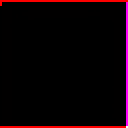

In [75]:
tensor_to_image(autoencoder(init_tensor).data)

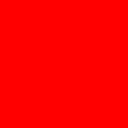

In [76]:
tensor_to_image(init_tensor.data)

In [10]:
from PIL import Image, ImageDraw
import random
import os

def generate_images(size, num_images, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for i in range(1, num_images + 1):
        # Create a new image with a random background color
        img = Image.new("RGB", size, color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

        # Get a drawing context
        draw = ImageDraw.Draw(img)

        # Choose a random shape (circle, square, or triangle)
        # shape = random.choice(["circle", "square", "triangle"])
        shape = "circle"

        # Choose a random position
        position = (random.randint(20, size[0]-20), random.randint(20, size[1]-20))

        # Choose a random color for the shape
        shape_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        # Draw the shape on the image
        if shape == "circle":
            draw.ellipse([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
        elif shape == "square":
            draw.rectangle([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
        elif shape == "triangle":
            draw.polygon([(position[0], position[1]-20), (position[0]-20, position[1]+20), (position[0]+20, position[1]+20)], fill=shape_color)

        # Save the image to the output folder
        img.save(os.path.join(output_folder, f"image_{i}.png"))

# Example usage
generate_images((128, 128), 20, "../data/dataset_test")

In [ ]:
class Dataset:
    def __init__(self, path) -> None:
        self.data = list(range(100))
        self.path = path

    def __len__(self) -> int:
        return len(self.data)

    def __str__(self) -> str:
        return f'Dataset(len={len(self)})'

    def __repr__(self) -> str:
        return str(self)
    
    def __getitem__(self, key : str|int) -> int:
        match key:
            case key if isinstance(key, str):
                raise ValueError('Dataset does not take string as index.')
            case _:
                return self.data[key]

In [12]:
from PIL import Image
import os

class ImageDataset:
    def __init__(self, path) -> None:
        self.path = path
        self.image_files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.data = [self.load_image(file) for file in self.image_files]

    def __len__(self) -> int:
        return len(self.data)

    def __str__(self) -> str:
        return f'ImageDataset(len={len(self)})'

    def __repr__(self) -> str:
        return str(self)

    def __getitem__(self, key: int) -> Image.Image:
        return self.data[key]

    def load_image(self, file: str) -> Image.Image:
        image_path = os.path.join(self.path, file)
        try:
            image = Image.open(image_path)
            return image
        except Exception as e:
            print(f"Error loading image '{file}': {e}")
            return None


In [25]:
device = torch.device('cuda')

In [26]:
path_dataset_train = "../data/dataset_train/"
path_dataset_test = "../data/dataset_test/"
dataset_train = ImageDataset(path_dataset_train).data
dataset_test = ImageDataset(path_dataset_test).data
autoencoder = AutoEncoder()
autoencoder.train()
lr = 1e-4
num_steps = 100

optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    loss_iter = 0
    for image in dataset_train:
        image = image_to_tensor(image)
        y = autoencoder(image)
        loss = (y-image).norm()
        loss_iter += loss
    loss = loss_iter/len(dataset_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

step 0 : loss 123.21394348144531
step 1 : loss 122.26897430419922
step 2 : loss 121.24037170410156
step 3 : loss 120.0500259399414
step 4 : loss 118.62422180175781
step 5 : loss 116.88932800292969
step 6 : loss 114.76747131347656
step 7 : loss 112.17282104492188
step 8 : loss 109.01488494873047
step 9 : loss 105.21585083007812
step 10 : loss 100.74581909179688
step 11 : loss 95.69642639160156
step 12 : loss 90.43476867675781
step 13 : loss 85.88189697265625
step 14 : loss 83.70207977294922
step 15 : loss 84.5237808227539
step 16 : loss 85.05467987060547
step 17 : loss 83.18534088134766
step 18 : loss 79.83197021484375
step 19 : loss 76.52706909179688
step 20 : loss 74.20878601074219
step 21 : loss 73.02535247802734
step 22 : loss 72.64973449707031
step 23 : loss 72.67387390136719
step 24 : loss 72.81929016113281
step 25 : loss 72.96639251708984
step 26 : loss 73.09656524658203
step 27 : loss 73.20834350585938
step 28 : loss 73.25165557861328
step 29 : loss 73.13587951660156
step 30 : l

In [52]:
import torch
import wandb
from torch.utils.data import DataLoader
import PIL

lr = 1e-4
num_steps = 1000

# Initialize wandb
wandb.init(project='finegrain-cs', config={
    'lr': lr,
    'num_steps': num_steps
})

path_dataset_train = "../data/dataset_train/"
path_dataset_test = "../data/dataset_test/"
dataset_train = ImageDataset(path_dataset_train).data
dataset_test = ImageDataset(path_dataset_test).data
autoencoder = AutoEncoder()
autoencoder.train()


optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)

# Convert your datasets to DataLoader for easy batch processing
# train_dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)

# Modify your training loop
for step in range(num_steps):
    loss_iter = 0
    for images in dataset_train:
        images = image_to_tensor(images)
        y = autoencoder(images)
        loss = (y - images).norm()
        loss_iter += loss

    loss = loss_iter / len(dataset_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Log the loss to wandb
    wandb.log({'step': step, 'loss': loss.item()})

    print(f"step {step} : loss {loss.item()}")

# Testing at the end of training
loss_iter_test = 0
reconstructed_images = []

with torch.no_grad():
    for images_test in dataset_test:
        images_test = image_to_tensor(images_test)
        y_test = autoencoder(images_test)
        loss_test = (y_test - images_test).norm()
        loss_iter_test += loss_test

        # # Append the reconstructed images for visualization
        concat = Image.new('RGB', (256, 128))
        concat.paste(tensor_to_image(images_test.data), (0, 0))
        concat.paste(tensor_to_image(y_test.data), (128, 0))
        
        reconstructed_images.append(concat)

images = [PIL.Image.fromarray(np.array(image)) for image in reconstructed_images]

wandb.log({"reconstructed_images": [wandb.Image(image) for image in images]})

loss_test = loss_iter_test / len(dataset_test)

# Log the test loss to wandb
wandb.log({'test_loss': loss_test.item()})

print(f"Test Loss at the end of training: {loss_test.item()}")


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,██▇▇▆▅▅▄▂▁
step,▁▂▃▃▄▅▆▆▇█
test_loss,▁
loss,111.20601
step,9
test_loss,113.12148


step 0 : loss 127.8471908569336
step 1 : loss 126.98172760009766
step 2 : loss 126.02904510498047
step 3 : loss 124.91508483886719
step 4 : loss 123.57235717773438
step 5 : loss 121.93327331542969
step 6 : loss 119.92459106445312
step 7 : loss 117.46563720703125
step 8 : loss 114.46715545654297
step 9 : loss 110.8344955444336
step 10 : loss 106.47940063476562
step 11 : loss 101.34246063232422
step 12 : loss 95.4439468383789
step 13 : loss 88.98930358886719
step 14 : loss 82.57461547851562
step 15 : loss 77.53211212158203
step 16 : loss 75.98564147949219
step 17 : loss 78.50843048095703
step 18 : loss 80.99042510986328
step 19 : loss 80.5259780883789
step 20 : loss 78.02440643310547
step 21 : loss 75.19908905029297
step 22 : loss 73.1849594116211
step 23 : loss 72.30620574951172
step 24 : loss 72.31853485107422
step 25 : loss 72.77925109863281
step 26 : loss 73.30518341064453
step 27 : loss 73.65884399414062
step 28 : loss 73.7333755493164
step 29 : loss 73.5112075805664
step 30 : loss 

In [ ]:
autoencoder.eval()
for image in dataset_test:
    image = image_to_tensor(image)
    result = autoencoder(image)
    tensor_to_image(image.data).show()
    tensor_to_image(result.data).show()

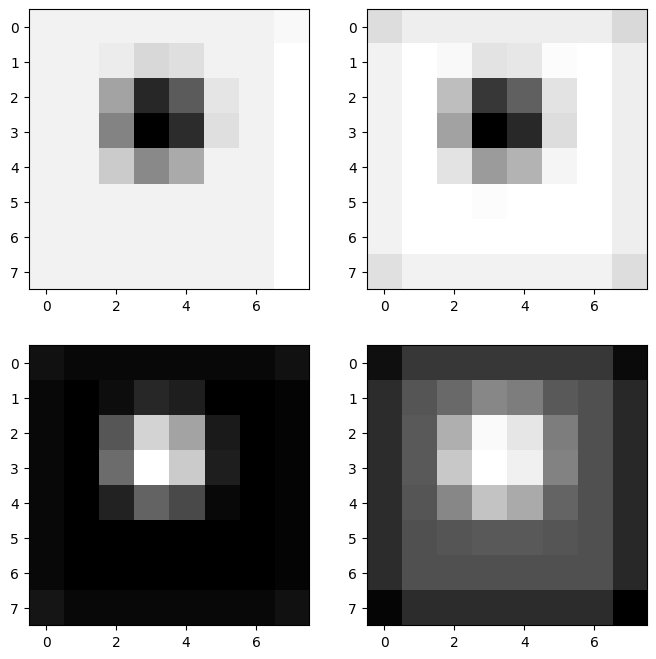

In [78]:
tensor = image_to_tensor(dataset_test[0])
latent = autoencoder.encoder(tensor)
latent = (latent - latent.min())/(latent.max() - latent.min())


#split latent into 4 channels
channels = latent.squeeze(0).split(1)

images = [tensor_to_image(channel.unsqueeze(0).detach()) for channel in channels]

#write function to make grid using matplotlib in grayscale colorscheme
def make_grid_using_matplotlib(images):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 8))

    columns = 2
    rows = 2
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)

        plt.imshow(images[i-1], cmap='gray')
    plt.show()

make_grid_using_matplotlib(images)
